In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr

# 1. VERİYİ YÜKLEME VE DÜZENLEME

file_path = 'calisma_saati_ve_puan_raw.csv' 
df = pd.read_csv(file_path)

# Sütun İsimlerini Kısaltma
rename_dict = {
    'Lisans Bölümünüz': 'bolum',
    'Sınıfınız (2025-2026 Güz Dönemi Dahilinde)': 'sinif',
    'Algoritmalar ve Veri Yapıları dersini kaç kere aldınız/alıyorsunuz? ': 'kacinci_alis',
    'Bu dersi çalışmak için haftada ders dışı ortalama kaç saat ayırıyorsunuz?': 'calisma_saati',
    'Algoritma ve Veri Yapıları dersinin vize sınavından kaç aldınız?': 'vize_notu'
}
df_cleaned = df.rename(columns=rename_dict)
df_cleaned = df_cleaned.drop(columns=[
    'Zaman damgası', 
    'BİL 2011 Algoritmalar ve Veri Yapıları dersini aldınız mı veya şu anda alıyor musunuz?',
    'Dersi hangi dönem aldınız/alıyorsunuz? (Birden fazla dönem işaretleyebilirsiniz.)'
], errors='ignore')

# 2. VERİ TEMİZLEME FONKSİYONLARI

def standardize_bolum(bolum):
    if pd.isna(bolum): return None
    bolum_lower = str(bolum).lower().strip()
    if any(x in bolum_lower for x in ['bilgisayar', 'computer', 'science', 'cs']) or bolum_lower == '4':
        return 'Bilgisayar Bilimleri'
    elif 'biyoloji' in bolum_lower:
        return 'Biyoloji'
    return None

def clean_kacinci_alis(val):
    """
    0 - İlk kez alıyor.
    Mantık: 'ilk' ise 0, değilse sayısal değer - 1 (örn: 2. kez -> 1 tekrar)
    """
    if pd.isna(val): return np.nan
    val_str = str(val).replace('İ', 'i').lower().strip() # Türkçe karakter düzeltmesi
    
    if 'ilk' in val_str or 'bir' in val_str:
        return 0  # İlk kez alıyorsa 0
    
    # İçindeki sayıyı bul
    val_clean = re.sub(r'[^\d]', '', val_str)
    try:
        count = int(val_clean)
        # Ödevde "Tekrar sayısı (0 - ilk kez)" dendiği için: 1. alış -> 0 tekrar, 2. alış -> 1 tekrar
        return count - 1 if count > 0 else 0 
    except:
        return np.nan

def clean_calisma_saati(val):
    if pd.isna(val): return np.nan
    val_str = str(val).lower().strip()
    # Dakika kontrolü
    if 'dakika' in val_str or 'dk' in val_str:
        try: return float(re.sub(r'[^\d.]', '', val_str)) / 60.0
        except: pass
    # Aralık (15-20 gibi özel durum)
    if "15-20" in val_str: return ((15 + 20) / 2) / 60
    # Tireli Aralık (1-2)
    if '-' in val_str:
        try:
            parts = [float(re.sub(r'[^\d.]', '', p)) for p in val_str.split('-') if re.sub(r'[^\d.]', '', p)]
            if len(parts) == 2: return sum(parts) / 2
        except: pass
    # Standart Sayı
    try: return float(re.sub(r'[^\d.]', '', val_str.replace(',', '.')))
    except: return np.nan

def clean_vize_notu(val):
    if pd.isna(val): return np.nan
    try: return float(re.sub(r'[^\d.]', '', str(val).replace(',', '.')))
    except: return np.nan

# Temizlik Uygulama
df_cleaned['bolum'] = df_cleaned['bolum'].apply(standardize_bolum)
df_cleaned = df_cleaned.dropna(subset=['bolum'])
df_cleaned['kacinci_alis'] = df_cleaned['kacinci_alis'].apply(clean_kacinci_alis)
df_cleaned['calisma_saati'] = df_cleaned['calisma_saati'].apply(clean_calisma_saati)
df_cleaned['vize_notu'] = df_cleaned['vize_notu'].apply(clean_vize_notu)

# Boş Verileri Silme ve Son Düzenlemeler
df_final = df_cleaned.dropna(subset=['calisma_saati', 'vize_notu', 'kacinci_alis']).copy()
df_final = df_final.reset_index(drop=True)

# İstenen Sütunları Ekleme
df_final.insert(0, 'ogrenci_id', range(1, len(df_final) + 1)) # ID
df_final['ders_adi'] = 'Algoritmalar ve Veri Yapıları'
df_final['haftalik_ders_saati'] = 3 # Varsayılan ders saati
df_final['akts'] = 6
df_final['kacinci_alis'] = df_final['kacinci_alis'].astype(int)

# Temiz Veriyi Kaydetme
df_final.to_csv('calisma_saati_ve_puan_cleaned.csv', index=False)
print("Veri seti calisma_saati_ve_puan_cleaned.csv' olarak kaydedildi.")
print(df_final.head())

Veri seti calisma_saati_ve_puan_cleaned.csv' olarak kaydedildi.
   ogrenci_id                 bolum     sinif  kacinci_alis  calisma_saati  \
0           1  Bilgisayar Bilimleri  3. sınıf             1           2.00   
1           2  Bilgisayar Bilimleri  2. sınıf             0           1.25   
2           3  Bilgisayar Bilimleri  2. sınıf             0           1.50   
3           4  Bilgisayar Bilimleri  2. sınıf             0           6.00   
4           5  Bilgisayar Bilimleri  2. sınıf             0           2.00   

   vize_notu                       ders_adi  haftalik_ders_saati  akts  
0       35.0  Algoritmalar ve Veri Yapıları                    3     6  
1       68.0  Algoritmalar ve Veri Yapıları                    3     6  
2       43.0  Algoritmalar ve Veri Yapıları                    3     6  
3       85.0  Algoritmalar ve Veri Yapıları                    3     6  
4       85.0  Algoritmalar ve Veri Yapıları                    3     6  


In [14]:
# --- REGRESYON ANALİZİ ---

X = df_final[['calisma_saati']]
y = df_final['vize_notu']

# Tahmin edilecek saatler (DataFrame formatında olmalı)
tahmin_df = pd.DataFrame([0.5, 1.0, 1.5, 2.0], columns=['calisma_saati'])

# Model 1: Lineer Regresyon
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_pred = lin_reg.predict(tahmin_df)

# Model 2: Polinom Regresyon (2. Derece)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
poly_pred = poly_reg.predict(poly.fit_transform(tahmin_df))

# Model 3: Karar Ağacı (Decision Tree)
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=3) # Aşırı uyumu (overfitting) önlemek için derinlik sınırı
tree_reg.fit(X, y)
tree_pred = tree_reg.predict(tahmin_df)

# Sonuç Tablosu
sonuc_tablosu = pd.DataFrame({
    'Çalışma Saati': tahmin_df['calisma_saati'],
    'Lineer Tahmin': lin_pred,
    'Polinom Tahmin': poly_pred,
    'Karar Ağacı Tahmin': tree_pred
})

print("\n--- Tahmin Sonuçları ---")
print(sonuc_tablosu)


--- Tahmin Sonuçları ---
   Çalışma Saati  Lineer Tahmin  Polinom Tahmin  Karar Ağacı Tahmin
0            0.5      53.724759       46.359034           38.333333
1            1.0      54.861127       52.950762           56.076923
2            1.5      55.997495       58.975275           65.416667
3            2.0      57.133863       64.432573           65.416667



--- İstatistiksel Analiz ---
Korelasyon Katsayısı (r): 0.2246
P-değeri: 0.1168
Lineer Model Eğimi (1 saatin etkisi): 2.2727


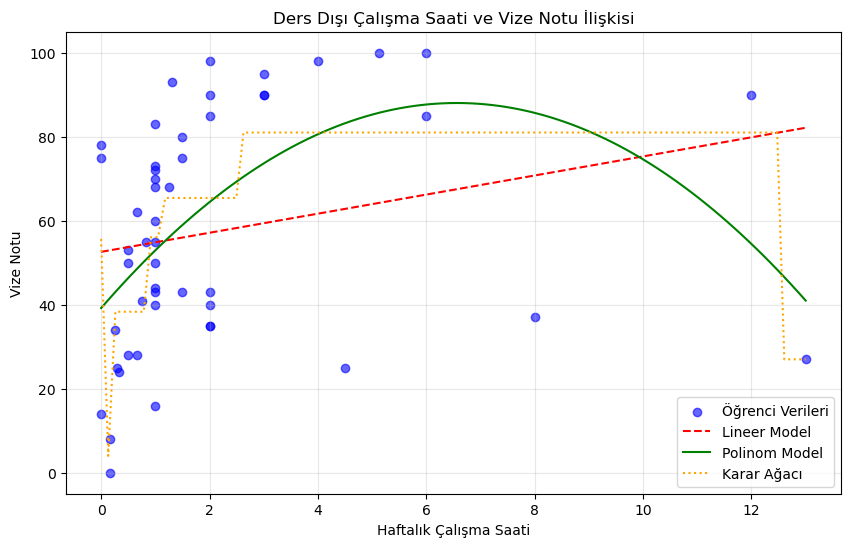

In [17]:
# İSTATİSTİKLER VE GRAFİK

korelasyon, p_value = pearsonr(df_final['calisma_saati'], df_final['vize_notu'])
egim = lin_reg.coef_[0]

print(f"\n--- İstatistiksel Analiz ---")
print(f"Korelasyon Katsayısı (r): {korelasyon:.4f}")
print(f"P-değeri: {p_value:.4f}")
print(f"Lineer Model Eğimi (1 saatin etkisi): {egim:.4f}")

# Grafik Çizimi
plt.figure(figsize=(10, 6))
plt.scatter(df_final['calisma_saati'], df_final['vize_notu'], color='blue', alpha=0.6, label='Öğrenci Verileri')

# Modellerin Çizgileri
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_df = pd.DataFrame(x_range, columns=['calisma_saati'])

plt.plot(x_range, lin_reg.predict(x_range_df), color='red', linestyle='--', label='Lineer Model')
plt.plot(x_range, poly_reg.predict(poly.fit_transform(x_range_df)), color='green', linestyle='-', label='Polinom Model')
plt.plot(x_range, tree_reg.predict(x_range_df), color='orange', linestyle=':', label='Karar Ağacı')

plt.title('Ders Dışı Çalışma Saati ve Vize Notu İlişkisi')
plt.xlabel('Haftalık Çalışma Saati')
plt.ylabel('Vize Notu')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Regresyon_Analizi_Grafigi.png')
plt.show()